In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Thu Jan 18 16:57:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   42C    P0    75W / 300W |  16828MiB / 80994MiB |      9%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.54it/s]

-2.929292929292929


In [7]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-2e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.1384], device='cuda:0', grad_fn=<ExpBackward0>)


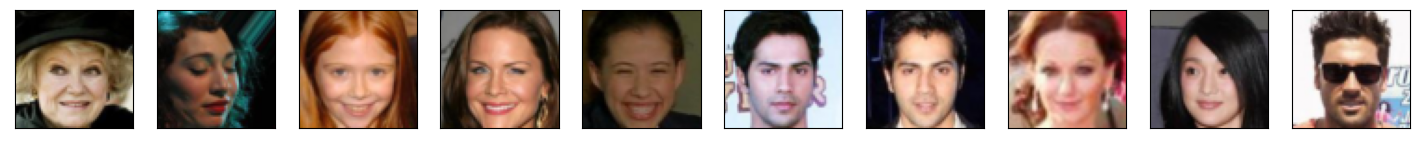

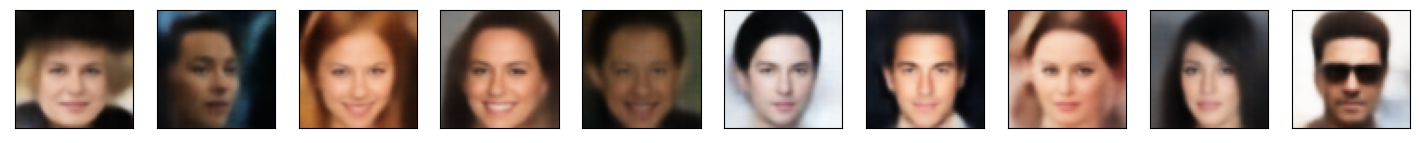

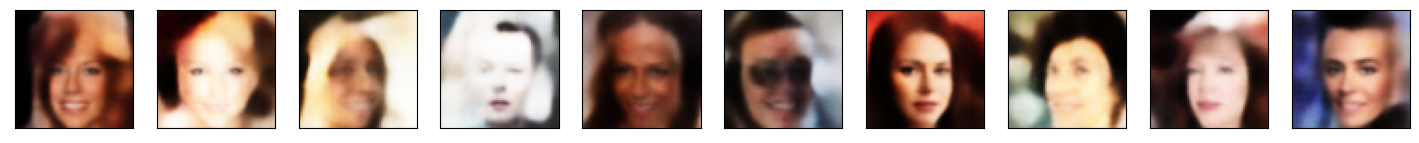

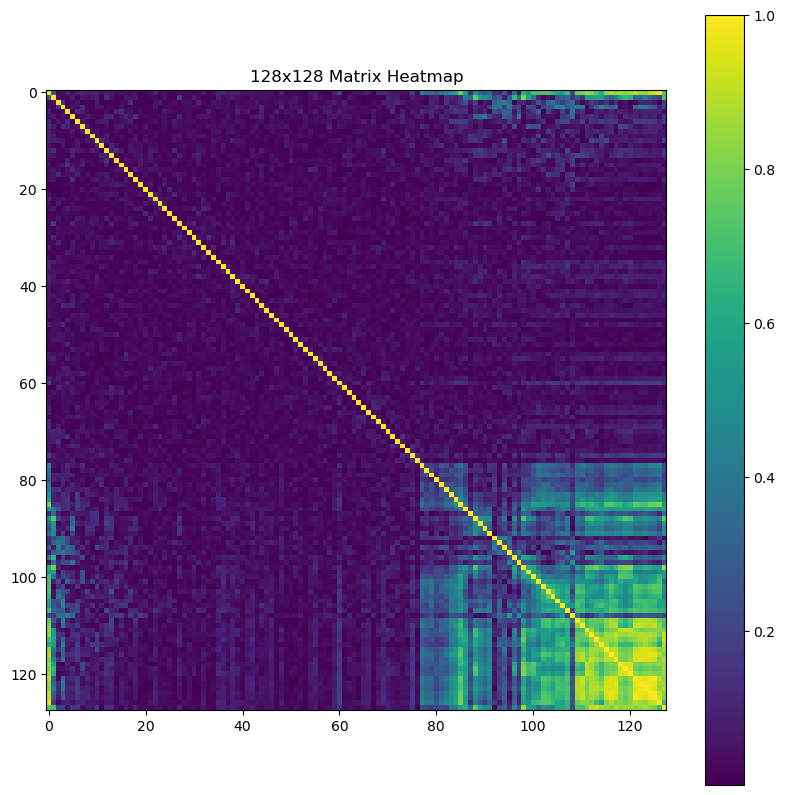

10001
lse_loss -0.5995289087295532
recon_loss 0.009935179725289345
10002
lse_loss -0.5990039110183716
recon_loss 0.009199123829603195
10003
lse_loss -0.6057668924331665
recon_loss 0.009298295713961124
10004
lse_loss -0.5978937149047852
recon_loss 0.009545564651489258
10005
lse_loss -0.6028664708137512
recon_loss 0.010619565844535828
10006
lse_loss -0.6005117893218994
recon_loss 0.009514736011624336
10007
lse_loss -0.6033754944801331
recon_loss 0.010989087633788586
10008
lse_loss -0.6020216941833496
recon_loss 0.010327313095331192
10009
lse_loss -0.6067485809326172
recon_loss 0.00985288992524147
10010
lse_loss -0.6054056882858276
recon_loss 0.009778572246432304
10011
lse_loss -0.6010881662368774
recon_loss 0.009211158379912376
10012
lse_loss -0.601577877998352
recon_loss 0.009413277730345726
10013
lse_loss -0.6046370267868042
recon_loss 0.00969228707253933
10014
lse_loss -0.6109944581985474
recon_loss 0.009133372455835342
10015
lse_loss -0.6041218042373657
recon_loss 0.01002087723463773

10124
lse_loss -0.5967169404029846
recon_loss 0.008709139190614223
10125
lse_loss -0.5944423675537109
recon_loss 0.00911463052034378
10126
lse_loss -0.5973021984100342
recon_loss 0.008572123944759369
10127
lse_loss -0.6017431020736694
recon_loss 0.009903466328978539
10128
lse_loss -0.5935051441192627
recon_loss 0.00907648541033268
10129
lse_loss -0.5929374098777771
recon_loss 0.00969417579472065
10130
lse_loss -0.5972113609313965
recon_loss 0.00902676209807396
10131
lse_loss -0.594886064529419
recon_loss 0.009287087246775627
10132
lse_loss -0.5926254987716675
recon_loss 0.010452027432620525
10133
lse_loss -0.5977672338485718
recon_loss 0.009217637591063976
10134
lse_loss -0.5931476950645447
recon_loss 0.008838342502713203
10135
lse_loss -0.6018989086151123
recon_loss 0.008328329771757126
10136
lse_loss -0.5941873788833618
recon_loss 0.008986230939626694
10137
lse_loss -0.5971980094909668
recon_loss 0.010985953733325005
10138
lse_loss -0.6046868562698364
recon_loss 0.00970864575356245
1

10247
lse_loss -0.6046010255813599
recon_loss 0.010600237175822258
10248
lse_loss -0.5995923280715942
recon_loss 0.010186495259404182
10249
lse_loss -0.5964498519897461
recon_loss 0.01023014634847641
10250
lse_loss -0.5958386659622192
recon_loss 0.011033736169338226
10251
lse_loss -0.597862720489502
recon_loss 0.009957528673112392
10252
lse_loss -0.6019946336746216
recon_loss 0.010071832686662674
10253
lse_loss -0.5913174152374268
recon_loss 0.008134529925882816
10254
lse_loss -0.5990182161331177
recon_loss 0.009664535522460938
10255
lse_loss -0.6015351414680481
recon_loss 0.009304443374276161
10256
lse_loss -0.5957441329956055
recon_loss 0.01019827090203762
10257
lse_loss -0.5968790054321289
recon_loss 0.010182922706007957
10258
lse_loss -0.5981631278991699
recon_loss 0.00980893149971962
10259
lse_loss -0.6055778861045837
recon_loss 0.009319796226918697
10260
lse_loss -0.5986887216567993
recon_loss 0.010688378475606441
10261
lse_loss -0.5977686047554016
recon_loss 0.009257229045033455

10370
lse_loss -0.6012457013130188
recon_loss 0.010059542022645473
10371
lse_loss -0.6002516746520996
recon_loss 0.010814441367983818
10372
lse_loss -0.5976906418800354
recon_loss 0.010187097825109959
10373
lse_loss -0.5939208269119263
recon_loss 0.009760517627000809
10374
lse_loss -0.5991595983505249
recon_loss 0.009763052687048912
10375
lse_loss -0.5991396307945251
recon_loss 0.009699205867946148
10376
lse_loss -0.5950788259506226
recon_loss 0.0097282063215971
10377
lse_loss -0.5919733047485352
recon_loss 0.008935599587857723
10378
lse_loss -0.596892237663269
recon_loss 0.009670468047261238
10379
lse_loss -0.5910953283309937
recon_loss 0.00958377867937088
10380
lse_loss -0.591279149055481
recon_loss 0.009567874483764172
10381
lse_loss -0.5935337543487549
recon_loss 0.009684007614850998
10382
lse_loss -0.5946194529533386
recon_loss 0.009948864579200745
10383
lse_loss -0.5917046666145325
recon_loss 0.010824630968272686
10384
lse_loss -0.5975644588470459
recon_loss 0.010361949913203716


10493
lse_loss -0.5996508598327637
recon_loss 0.009503372013568878
10494
lse_loss -0.5968703031539917
recon_loss 0.010520956479012966
10495
lse_loss -0.6023728847503662
recon_loss 0.009650787338614464
10496
lse_loss -0.5973297953605652
recon_loss 0.009423305280506611
10497
lse_loss -0.6007771492004395
recon_loss 0.008659975603222847
10498
lse_loss -0.6001948118209839
recon_loss 0.009117726236581802
10499
lse_loss -0.5987206697463989
recon_loss 0.009199313819408417
10500
lse_loss -0.6029424071311951
recon_loss 0.010669060051441193
10501
lse_loss -0.6014546155929565
recon_loss 0.009844118729233742
10502
lse_loss -0.5953410267829895
recon_loss 0.009218319319188595
10503
lse_loss -0.6023306846618652
recon_loss 0.01044679619371891
10504
lse_loss -0.5875652432441711
recon_loss 0.009283546358346939
10505
lse_loss -0.5928254127502441
recon_loss 0.008863167837262154
10506
lse_loss -0.5923058986663818
recon_loss 0.00958172231912613
10507
lse_loss -0.5974644422531128
recon_loss 0.0095562273636460

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 2e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
            
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
            
            from util.mmd_penalty import mmd_penalty
            opts = {'pz_scale': 1,
                    'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
                    'pz': 'normal', # 'normal', 'sphere', 'uniform' 
                    'zdim': hp.z_dim
                   } 
            e = (torch.rand_like(data['z_copy'])*2-1)
            mmd = mmd_penalty(data['z_copy'], e, opts).item()
            writer.add_scalar('MMD', mmd, step)
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [13]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


In [14]:
print('done')

done
